In [1]:
import os
import os.path
import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                                                                                                                       
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn import svm
from sklearn.model_selection import GridSearchCV
import sklearn_evaluation.plot as skplot
from sklearn.model_selection import learning_curve

import matplotlib.pyplot as plt

import numpy as np
np.random.seed(1)

from keras.preprocessing.image import img_to_array
from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.inception_v3 import InceptionV3,preprocess_input

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

Using TensorFlow backend.


In [2]:
imagedir = "Datasets/Detection/Byteplots"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:          Banker	Number of images: 1986
Label: 1	Family:          WinExe	Number of images: 1945
Processing images ...


/usr/local/lib/python2.7/dist-packages/PIL/Image.py:2371: DecompressionBombWarning: Image size (103265280 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
/usr/local/lib/python2.7/dist-packages/PIL/Image.py:2371: DecompressionBombWarning: Image size (110601216 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Images processed: 3931


In [4]:
X.shape

(3931, 224, 224, 3)

In [5]:
# Creating base_model
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = InceptionV3(weights='imagenet', input_shape=image_shape, include_top=False, pooling='avg')

In [6]:
print("Extracting bottleneck features from convolutional layers ...")
bnfeatures = base_model.predict(X)

Extracting bottleneck features from convolutional layers ...


In [7]:
bnfeatures.shape

(3931, 2048)

In [8]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 5  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)

In [9]:
# Training top_model
C_range = np.logspace(-2, 3, 6)
gamma_range = np.logspace(-8, 1, 10)
param_grid = dict(gamma=gamma_range, C=C_range)

top_model = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=skf, verbose=10, n_jobs=-1)
top_model.fit(bnfeatures,y)  # Training 

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-06 .............................................
[CV] C=0.01, gamma=1e-06 .............................................
[CV] C=0.01, gamma=1e-06 .............................................
[CV] C=0.01, ga

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  3.4min


[CV] .............. C=0.01, gamma=1e-06, score=0.505089, total= 1.9min
[CV] ............. C=0.01, gamma=0.0001, score=0.505089, total= 1.9min
[CV] C=0.01, gamma=0.001 .............................................
[CV] C=0.01, gamma=0.001 .............................................
[CV] ............. C=0.01, gamma=0.0001, score=0.505718, total= 1.9min
[CV] C=0.01, gamma=0.001 .............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.505089, total= 1.9min
[CV] C=0.01, gamma=0.001 .............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.505089, total= 1.9min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .............. C=0.01, gamma=1e-05, score=0.505089, total= 1.9min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.505718, total= 1.9min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  3.7min


[CV] .............. C=0.01, gamma=1e-06, score=0.505089, total= 2.1min
[CV] C=0.01, gamma=0.1 ...............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.505718, total= 2.1min
[CV] C=0.01, gamma=0.1 ...............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.505089, total= 2.1min
[CV] C=0.01, gamma=1.0 ...............................................
[CV] .............. C=0.01, gamma=1e-08, score=0.505089, total= 2.1min
[CV] C=0.01, gamma=1.0 ...............................................
[CV] .............. C=0.01, gamma=1e-08, score=0.505089, total= 2.1min
[CV] C=0.01, gamma=1.0 ...............................................
[CV] .............. C=0.01, gamma=1e-05, score=0.505089, total= 2.1min
[CV] C=0.01, gamma=1.0 ...............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.505089, total= 2.1min
[CV] .............. C=0.01, gamma=1e-07, score=0.505089, total= 2.1min
[CV] C

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  3.8min


[CV] .............. C=0.01, gamma=0.001, score=0.870394, total= 1.6min
[CV] .............. C=0.01, gamma=0.001, score=0.856234, total= 1.6min
[CV] C=0.01, gamma=10.0 ..............................................
[CV] C=0.01, gamma=10.0 ..............................................
[CV] .............. C=0.01, gamma=0.001, score=0.848601, total= 1.6min
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] .............. C=0.01, gamma=0.001, score=0.885496, total= 1.6min
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] .............. C=0.01, gamma=0.001, score=0.857506, total= 1.6min
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] ............. C=0.01, gamma=0.0001, score=0.505089, total= 2.0min
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] ............... C=0.01, gamma=0.01, score=0.837150, total= 2.0min
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  7.2min


[CV] ................ C=0.01, gamma=0.1, score=0.505089, total= 2.0min
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] ................ C=0.01, gamma=1.0, score=0.505718, total= 2.0min
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] ................ C=0.01, gamma=0.1, score=0.505089, total= 2.0min
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] ............... C=0.01, gamma=10.0, score=0.505718, total= 2.0min
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] ................ C=0.01, gamma=0.1, score=0.505089, total= 2.0min
[CV] C=0.1, gamma=1e-05 ..............................................
[CV] ................ C=0.01, gamma=1.0, score=0.505089, total= 2.0min
[CV] ................ C=0.01, gamma=1.0, score=0.505089, total= 2.0min
[CV] C=0.1, gamma=1e-05 ..............................................
[CV] ................ C=0.01, gamma=1.0, score=0.505089, total= 2.0min
[CV] C

[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed: 10.0min


[CV] ............... C=0.01, gamma=10.0, score=0.505089, total= 2.0min
[CV] C=0.1, gamma=0.0001 .............................................
[CV] ............... C=0.1, gamma=1e-08, score=0.505718, total= 2.0min
[CV] C=0.1, gamma=0.001 ..............................................
[CV] ............... C=0.1, gamma=1e-08, score=0.505089, total= 2.0min
[CV] ............... C=0.1, gamma=1e-08, score=0.505089, total= 2.1min
[CV] C=0.1, gamma=0.001 ..............................................
[CV] C=0.1, gamma=0.001 ..............................................
[CV] .............. C=0.1, gamma=0.0001, score=0.853690, total= 1.4min
[CV] C=0.1, gamma=0.001 ..............................................
[CV] ............... C=0.1, gamma=1e-08, score=0.505089, total= 2.0min
[CV] C=0.1, gamma=0.001 ..............................................
[CV] ............... C=0.1, gamma=1e-06, score=0.505718, total= 1.9min
[CV] C=0.1, gamma=0.01 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed: 10.8min


[CV] ............... C=0.1, gamma=1e-05, score=0.505089, total= 1.9min
[CV] ............... C=0.1, gamma=1e-05, score=0.505089, total= 1.9min
[CV] C=0.1, gamma=1.0 ................................................
[CV] C=0.1, gamma=0.1 ................................................
[CV] ............... C=0.1, gamma=1e-07, score=0.505089, total= 2.0min
[CV] C=0.1, gamma=1.0 ................................................
[CV] ............... C=0.1, gamma=1e-06, score=0.505089, total= 1.9min
[CV] C=0.1, gamma=1.0 ................................................
[CV] ............... C=0.1, gamma=1e-07, score=0.505089, total= 2.0min
[CV] C=0.1, gamma=1.0 ................................................
[CV] ............... C=0.1, gamma=1e-05, score=0.505089, total= 2.0min
[CV] C=0.1, gamma=1.0 ................................................
[CV] ............... C=0.1, gamma=1e-05, score=0.505089, total= 1.9min
[CV] C=0.1, gamma=10.0 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed: 12.6min


[CV] ................ C=0.1, gamma=0.01, score=0.852605, total= 1.4min
[CV] C=1.0, gamma=1e-08 ..............................................
[CV] ................ C=0.1, gamma=0.01, score=0.881679, total= 1.4min
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] ................ C=0.1, gamma=0.01, score=0.888041, total= 1.4min
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] ................ C=0.1, gamma=0.01, score=0.857506, total= 1.4min
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] ................ C=0.1, gamma=0.01, score=0.867684, total= 1.4min
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] ................. C=0.1, gamma=0.1, score=0.516539, total= 1.9min
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] ................. C=0.1, gamma=0.1, score=0.515883, total= 1.9min
[CV] C=1.0, gamma=1e-06 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 15.3min


[CV] ................ C=0.1, gamma=10.0, score=0.505089, total= 2.0min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ................ C=0.1, gamma=10.0, score=0.505089, total= 2.0min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ................ C=0.1, gamma=10.0, score=0.505089, total= 2.0min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ............... C=1.0, gamma=1e-08, score=0.505089, total= 1.9min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ............... C=1.0, gamma=1e-08, score=0.505718, total= 2.0min
[CV] C=1.0, gamma=0.001 ..............................................
[CV] ............... C=1.0, gamma=1e-08, score=0.505089, total= 2.0min
[CV] C=1.0, gamma=0.001 ..............................................
[CV] ............... C=1.0, gamma=1e-08, score=0.505089, total= 2.0min
[CV] C=1.0, gamma=0.001 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed: 16.9min


[CV] ............... C=1.0, gamma=1e-07, score=0.505089, total= 2.0min
[CV] C=1.0, gamma=0.1 ................................................
[CV] ............... C=1.0, gamma=1e-05, score=0.860051, total= 1.4min
[CV] C=1.0, gamma=0.1 ................................................
[CV] ............... C=1.0, gamma=1e-05, score=0.888041, total= 1.4min
[CV] C=1.0, gamma=1.0 ................................................
[CV] ............... C=1.0, gamma=1e-05, score=0.856234, total= 1.4min
[CV] C=1.0, gamma=1.0 ................................................
[CV] ............... C=1.0, gamma=0.001, score=0.945362, total=  38.4s
[CV] C=1.0, gamma=1.0 ................................................
[CV] .............. C=1.0, gamma=0.0001, score=0.893130, total=  45.6s
[CV] C=1.0, gamma=1.0 ................................................
[CV] ............... C=1.0, gamma=0.001, score=0.931298, total=  37.5s
[CV] C=1.0, gamma=1.0 ................................................
[CV] .

[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed: 19.2min


[CV] ................ C=1.0, gamma=0.01, score=0.908397, total= 1.6min
[CV] C=10.0, gamma=1e-07 .............................................
[CV] ................ C=1.0, gamma=0.01, score=0.930025, total= 1.9min
[CV] C=10.0, gamma=1e-07 .............................................
[CV] ................. C=1.0, gamma=0.1, score=0.634053, total= 2.1min
[CV] C=10.0, gamma=1e-07 .............................................
[CV] ................. C=1.0, gamma=0.1, score=0.650127, total= 2.0min
[CV] C=10.0, gamma=1e-06 .............................................
[CV] ................. C=1.0, gamma=0.1, score=0.678117, total= 2.0min
[CV] C=10.0, gamma=1e-06 .............................................
[CV] ................. C=1.0, gamma=0.1, score=0.667939, total= 2.0min
[CV] C=10.0, gamma=1e-06 .............................................
[CV] ................. C=1.0, gamma=0.1, score=0.639949, total= 2.0min
[CV] C=10.0, gamma=1e-06 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed: 21.2min


[CV] .............. C=10.0, gamma=1e-08, score=0.505089, total= 1.9min
[CV] C=10.0, gamma=0.001 .............................................
[CV] .............. C=10.0, gamma=1e-08, score=0.505089, total= 1.9min
[CV] C=10.0, gamma=0.001 .............................................
[CV] ............. C=10.0, gamma=0.0001, score=0.930025, total=  32.6s
[CV] C=10.0, gamma=0.001 .............................................
[CV] ............. C=10.0, gamma=0.0001, score=0.942821, total=  34.3s
[CV] C=10.0, gamma=0.001 .............................................
[CV] ............. C=10.0, gamma=0.0001, score=0.922392, total=  33.1s
[CV] C=10.0, gamma=0.01 ..............................................
[CV] ............. C=10.0, gamma=0.0001, score=0.935115, total=  33.6s
[CV] C=10.0, gamma=0.01 ..............................................
[CV] ............. C=10.0, gamma=0.0001, score=0.942748, total=  35.2s
[CV] C=10.0, gamma=0.01 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 23.0min


[CV] .............. C=10.0, gamma=1e-06, score=0.876747, total= 1.4min
[CV] C=10.0, gamma=10.0 ..............................................
[CV] .............. C=10.0, gamma=0.001, score=0.947837, total=  34.0s
[CV] C=10.0, gamma=10.0 ..............................................
[CV] .............. C=10.0, gamma=1e-06, score=0.853690, total= 1.4min
[CV] C=10.0, gamma=10.0 ..............................................
[CV] .............. C=10.0, gamma=1e-06, score=0.860051, total= 1.4min
[CV] C=100.0, gamma=1e-08 ............................................
[CV] .............. C=10.0, gamma=1e-06, score=0.888041, total= 1.4min
[CV] C=100.0, gamma=1e-08 ............................................
[CV] .............. C=10.0, gamma=1e-07, score=0.505089, total= 2.0min
[CV] C=100.0, gamma=1e-08 ............................................
[CV] .............. C=10.0, gamma=1e-07, score=0.505089, total= 2.0min
[CV] C=100.0, gamma=1e-08 ............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed: 26.2min


[CV] ............... C=10.0, gamma=10.0, score=0.531807, total= 1.9min
[CV] C=100.0, gamma=1e-05 ............................................
[CV] ............... C=10.0, gamma=10.0, score=0.532402, total= 1.9min
[CV] C=100.0, gamma=1e-05 ............................................
[CV] ............... C=10.0, gamma=10.0, score=0.529262, total= 1.9min
[CV] C=100.0, gamma=0.0001 ...........................................
[CV] ................ C=10.0, gamma=1.0, score=0.571247, total= 2.1min
[CV] C=100.0, gamma=0.0001 ...........................................
[CV] ............... C=10.0, gamma=10.0, score=0.536896, total= 2.0min
[CV] C=100.0, gamma=0.0001 ...........................................
[CV] ............... C=10.0, gamma=10.0, score=0.544529, total= 2.0min
[CV] C=100.0, gamma=0.0001 ...........................................
[CV] ............. C=100.0, gamma=1e-08, score=0.505089, total= 2.0min
[CV] C=100.0, gamma=0.0001 ...........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed: 27.5min


[CV] ............. C=100.0, gamma=1e-07, score=0.860051, total= 1.4min
[CV] C=100.0, gamma=1.0 ..............................................
[CV] ............ C=100.0, gamma=0.0001, score=0.945293, total=  31.0s
[CV] C=100.0, gamma=1.0 ..............................................
[CV] ............ C=100.0, gamma=0.0001, score=0.945293, total=  31.3s
[CV] C=100.0, gamma=1.0 ..............................................
[CV] ............ C=100.0, gamma=0.0001, score=0.956743, total=  31.3s
[CV] C=100.0, gamma=1.0 ..............................................
[CV] ............ C=100.0, gamma=0.0001, score=0.921120, total=  29.0s
[CV] C=100.0, gamma=10.0 .............................................
[CV] ............. C=100.0, gamma=1e-08, score=0.505089, total= 2.0min
[CV] C=100.0, gamma=10.0 .............................................
[CV] ............. C=100.0, gamma=0.001, score=0.956798, total=  37.5s
[CV] C=100.0, gamma=10.0 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed: 30.8min


[CV] ............... C=100.0, gamma=0.1, score=0.674300, total= 1.9min
[CV] C=1000.0, gamma=1e-06 ...........................................
[CV] ............ C=1000.0, gamma=1e-08, score=0.888041, total= 1.4min
[CV] C=1000.0, gamma=1e-05 ...........................................
[CV] ............... C=100.0, gamma=0.1, score=0.645038, total= 1.9min
[CV] C=1000.0, gamma=1e-05 ...........................................
[CV] ............... C=100.0, gamma=0.1, score=0.642948, total= 2.0min
[CV] C=1000.0, gamma=1e-05 ...........................................
[CV] ............... C=100.0, gamma=1.0, score=0.555273, total= 2.0min
[CV] C=1000.0, gamma=1e-05 ...........................................
[CV] ............... C=100.0, gamma=1.0, score=0.561069, total= 2.0min
[CV] C=1000.0, gamma=1e-05 ...........................................
[CV] ............... C=100.0, gamma=1.0, score=0.566158, total= 2.0min
[CV] C=1000.0, gamma=0.0001 ..........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 284 out of 300 | elapsed: 34.2min remaining:  1.9min


[CV] ............. C=1000.0, gamma=0.01, score=0.947837, total= 1.6min
[CV] .............. C=1000.0, gamma=0.1, score=0.642948, total= 1.7min
[CV] .............. C=1000.0, gamma=0.1, score=0.674300, total= 1.7min
[CV] .............. C=1000.0, gamma=0.1, score=0.660305, total= 1.7min
[CV] .............. C=1000.0, gamma=0.1, score=0.645038, total= 1.7min
[CV] .............. C=1000.0, gamma=1.0, score=0.561069, total= 1.7min
[CV] .............. C=1000.0, gamma=0.1, score=0.680662, total= 1.8min
[CV] ............. C=1000.0, gamma=10.0, score=0.532402, total= 1.6min
[CV] .............. C=1000.0, gamma=1.0, score=0.561069, total= 1.7min
[CV] .............. C=1000.0, gamma=1.0, score=0.555273, total= 1.8min
[CV] ............. C=1000.0, gamma=10.0, score=0.529262, total= 1.6min
[CV] .............. C=1000.0, gamma=1.0, score=0.566158, total= 1.8min
[CV] ............. C=1000.0, gamma=10.0, score=0.536896, total= 1.8min
[CV] .............. C=1000.0, gamma=1.0, score=0.571247, total= 1.8min
[CV] .

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 35.0min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'C': array([  1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02,   1.00000e+03]), 'gamma': array([  1.00000e-08,   1.00000e-07,   1.00000e-06,   1.00000e-05,
         1.00000e-04,   1.00000e-03,   1.00000e-02,   1.00000e-01,
         1.00000e+00,   1.00000e+01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=10)

In [10]:
top_model.cv_results_

{'mean_fit_time': array([ 101.26657801,   98.31957207,   94.64918785,   94.487397  ,
          91.52310719,   75.400246  ,   94.34263201,   95.97992125,
          95.42317958,   96.08304238,   97.9392024 ,   96.56565204,
          92.77252417,   92.79931798,   67.51371555,   43.0624536 ,
          66.87487955,   92.76325049,   95.38754778,   95.72929888,
          93.76639276,   92.99080682,   91.77905478,   66.29228287,
          39.75542974,   29.75789042,   79.42318997,   98.03892879,
          96.36565495,   93.39115024,   91.654528  ,   92.83682647,
          67.04785867,   40.23666801,   27.49727564,   27.64752946,
          82.70664196,   95.61201806,   94.73098407,   93.45836554,
          95.11800737,   64.44139614,   38.95013762,   27.65256076,
          25.19998565,   30.8407424 ,   82.66071281,   93.74365525,
          96.95695877,   95.74131365,   65.58944235,   37.75560327,
          27.92986794,   24.69325619,   26.80739236,   30.56664681,
          80.04224997,   85.867

In [11]:
top_model.grid_scores_

/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.50521, std: 0.00025, params: {'C': 0.01, 'gamma': 1e-08},
 mean: 0.50521, std: 0.00025, params: {'C': 0.01, 'gamma': 9.9999999999999995e-08},
 mean: 0.50521, std: 0.00025, params: {'C': 0.01, 'gamma': 9.9999999999999995e-07},
 mean: 0.50521, std: 0.00025, params: {'C': 0.01, 'gamma': 1.0000000000000001e-05},
 mean: 0.50521, std: 0.00025, params: {'C': 0.01, 'gamma': 0.0001},
 mean: 0.86365, std: 0.01298, params: {'C': 0.01, 'gamma': 0.001},
 mean: 0.85729, std: 0.01716, params: {'C': 0.01, 'gamma': 0.01},
 mean: 0.50521, std: 0.00025, params: {'C': 0.01, 'gamma': 0.10000000000000001},
 mean: 0.50521, std: 0.00025, params: {'C': 0.01, 'gamma': 1.0},
 mean: 0.50521, std: 0.00025, params: {'C': 0.01, 'gamma': 10.0},
 mean: 0.50521, std: 0.00025, params: {'C': 0.10000000000000001, 'gamma': 1e-08},
 mean: 0.50521, std: 0.00025, params: {'C': 0.10000000000000001, 'gamma': 9.9999999999999995e-08},
 mean: 0.50521, std: 0.00025, params: {'C': 0.10000000000000001, 'gamma': 9.99999999999

In [12]:
print("Best parameters: %s - score: %0.4f" % (top_model.best_params_, top_model.best_score_))

Best parameters: {'C': 10.0, 'gamma': 0.001} - score: 0.9517


/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


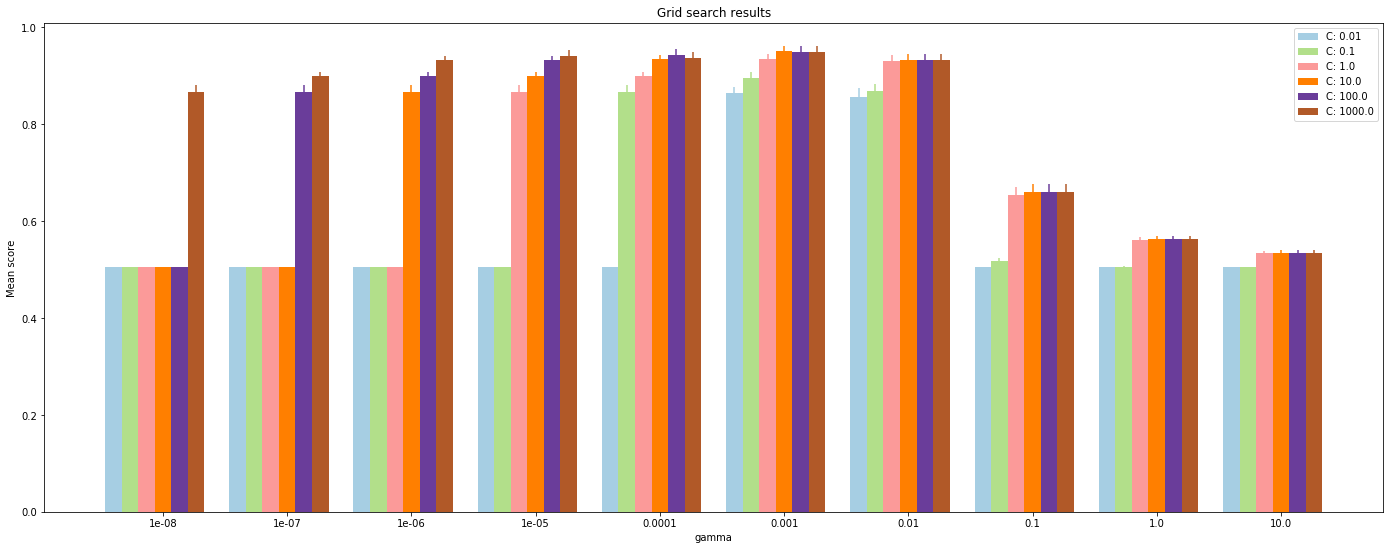

In [13]:
plt.rcParams['image.cmap'] = 'Paired'
skplot.grid_search(top_model.grid_scores_, change='gamma', kind='bar')
figure = plt.gcf()
figure.set_size_inches(24, 9)
plt.show()